In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import itertools
import time

In [21]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
data = pd.read_csv('data/character-predictions_pose.csv')
def clean(characters):
    # selected columns I think might be relevant
    characters = characters.loc[:,['name', 'male', 'house', 'isNoble', 'numDeadRelations', 'popularity', 'isAlive', 'culture', 'boolDeadRelations', 'isPopular']]
    # deleted all observations that have NaNs
    characters = characters[~characters.isnull().any(axis=1)]
    characters.reset_index(inplace = True, drop = True)
    
    # clean cultures 

    culture_counts = pd.DataFrame(characters.culture.value_counts())

    #combining culture names that mean the same thing 
    characters.culture = characters.culture.replace(to_replace = "northmen", value = "Northmen")
    characters.culture = characters.culture.replace(to_replace = "ironborn", value = "Ironborn")
    characters.culture = characters.culture.replace(to_replace = "Ironmen", value = "Ironborn")
    characters.culture = characters.culture.replace(to_replace = "Asshai'i", value = "Asshai")
    characters.culture = characters.culture.replace(to_replace = "Free folk", value = "Free Folk")
    characters.culture = characters.culture.replace(to_replace = "free folk", value = "Free Folk")
    characters.culture = characters.culture.replace(to_replace = "Summer Islands", value = "Summer Isles")
    characters.culture = characters.culture.replace(to_replace = "Summer Islander", value = "Summer Isles")
    characters.culture = characters.culture.replace(to_replace = "westermen", value = "Westermen")
    characters.culture = characters.culture.replace(to_replace = "Westerman", value = "Westermen")
    characters.culture = characters.culture.replace(to_replace = "Westerlands", value = "Westermen")
    characters.culture = characters.culture.replace(to_replace = "Vale", value = "Valemen")
    characters.culture = characters.culture.replace(to_replace = "Lhazareen", value = "Lhazarene")
    characters.culture = characters.culture.replace(to_replace = "The Reach", value = "Reach")
    characters.culture = characters.culture.replace(to_replace = "Reachmen", value = "Reach")
    characters.culture = characters.culture.replace(to_replace = "Qarth", value = "Qartheen")
    characters.culture = characters.culture.replace(to_replace = "Lyseni", value = "Lysene")
    characters.culture = characters.culture.replace(to_replace = "Stormlander", value = "Stormlands")
    characters.culture = characters.culture.replace(to_replace = "Meereenese", value = "Meereen")
    characters.culture = characters.culture.replace(to_replace = "Astapor", value = "Astapori")
    characters.culture = characters.culture.replace(to_replace = "Norvos", value = "Norvoshi")
    characters.culture = characters.culture.replace(to_replace = "Wildlings", value = "Wildling")
    characters.culture = characters.culture.replace(to_replace = "Andals", value = "Andal")
    characters.culture = characters.culture.replace(to_replace = "Braavos", value = "Braavosi")
    characters.culture = characters.culture.replace(to_replace = "Dorne", value = "Dornish")
    characters.culture = characters.culture.replace(to_replace = "Dornishmen", value = "Dornish")
    characters.culture = characters.culture.replace(to_replace = "Ghiscaricari", value = "Ghiscari")

    #getting survival rates per culture 
    culture_counts = pd.DataFrame(characters.culture.value_counts()).reset_index()
    survival_counts = pd.DataFrame(characters.groupby(['culture']).isAlive.value_counts())
    survival_counts.rename({'isAlive':'count_survived'}, axis='columns', inplace=True)
    survival_counts = pd.DataFrame(survival_counts.to_records())
    #for Qohor and Astapori, no one survived — this will be taken into account later and for now they will be dropped
    survival_counts = survival_counts[survival_counts['isAlive'] == 1] 
    survival_counts.drop(columns=["isAlive"], inplace=True)
    culture_counts = culture_counts.rename(columns={'index':'culture', "culture" : "total"})
    survival_df = culture_counts.merge(survival_counts)
    survival_df['percent_survived'] = (survival_df['count_survived']/survival_df['total'])*100
    survival_df = survival_df.sort_values(by=['percent_survived'], ascending=False)

    #grouping cultures based on their survival rates
    characters.culture = characters.culture.replace(to_replace = ['Ibbenese', 'Asshai', 'Lhazarene', 'Summer Isles', 'First Men', 'Naathi', 'Norvoshi', 'Rhoynar', 'Crannogmen'], value = "all_survive")
    characters.culture = characters.culture.replace(to_replace = ['Ironborn', 'Ghiscari', 'Vale mountain clans', 'Dornish', 'Reach'], value = "most_survive")
    characters.culture = characters.culture.replace(to_replace = ['Dothraki', 'Stormlands', 'Rivermen', 'Braavosi', 'Northmen'], value = "many_survive")
    characters.culture = characters.culture.replace(to_replace = ['Qartheen', 'Myrish', 'Lysene', 'Valemen', 'Northern mountain clans', 'Tyroshi', 'Westeros'], value = "morethanhalf_survive")
    characters.culture = characters.culture.replace(to_replace = ['Westermen', 'Riverlands', 'Pentoshi', 'Free Folk', 'Sistermen', 'Meereen'], value = "half_survive")
    characters.culture = characters.culture.replace(to_replace = ['Riverlands', 'Lysene', 'Valyrian'], value = "few_survive")
    characters.culture = characters.culture.replace(to_replace = ['Wildling', 'Valyrian'], value = "few_survive")
    characters.culture = characters.culture.replace(to_replace = ['Astapori', 'Qohor'], value = "none_survive")



    culture_counts = pd.DataFrame(characters.culture.value_counts()).reset_index()
    culture_counts = culture_counts.rename(columns={'index':'culture', "culture" : "count"})
    display(culture_counts)
    
    
    for house in characters.house:

        percent_alive = characters[characters.house == house].isAlive.mean()

        characters.loc[characters.house == house, 'house_alive'] = percent_alive



    # Bin house_alive into 5 bins

    binned_house_alive = pd.qcut(characters['house_alive'],10,retbins=True, duplicates = 'drop')

    bins = binned_house_alive[1]

    characters['house_alive_binned'] = pd.cut(characters['house_alive'],bins = bins)

    dum = pd.get_dummies(characters.house_alive_binned,drop_first = True)

    dum.columns = ['house_alive'+str(x) for x in range(1,len(bins)-1)]

    characters = pd.concat([characters,dum], axis = 1)

 

    age_data = characters.groupby('house_alive_binned')['isAlive'].agg([('percent','mean'),('nobs','count')]).reset_index(drop=False)

    # sns.lineplot(x = age_data.index, y= age_data['percent'])

    # plt.xlabel('house_bin')
    
    return characters
characters = clean(data)

,culture,count
0,most_survive,186
1,many_survive,167
2,morethanhalf_survive,49
3,few_survive,44
4,half_survive,29
5,all_survive,15
6,none_survive,3


In [22]:
def bin_opp(num):
    return 1 if num==0 else 0

In [8]:
def test_person(name, formula, data = characters):
    train = data.loc[data['name'] != name]
    person = data.loc[data['name'] == name]
    model = sm.logit(formula = formula, data=data).fit()
    prediction = model.predict(person)
    return prediction.values[0], person["isAlive"].values[0]

In [19]:
def test(formula, num_examples=50, loss_func=None, cutoff=.3, clean_data=characters):
    accurate_counter = 0
    mat_state = [[0,0],[0,0]]
    for index, row in clean_data.iterrows():
        p, act = test_person(row['name'], formula, data = clean_data)
        if p + cutoff >= 1:
            bin_p = 1
        else:
            bin_p = 0
        mat_state[bin_opp(bin_p)][bin_opp(act)] += 1
        if index >= num_examples:
            break
    if loss_func is None:
        return mat_state[0][0]+mat_state[1][1], mat_state
    else:
        return loss_func(accurate_counter), mat_state

In [33]:
X = characters[['male', 'house_alive_binned', 'isNoble', 'numDeadRelations', 'popularity', 'culture', 'boolDeadRelations', 'isPopular']]

In [30]:
#Function to develop a model based on all predictors in predictor_subset
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    print('isAlive~' + '+'.join(predictor_subset))
    model = sm.logit('isAlive~' + '+'.join(predictor_subset),data = characters).fit()
    accuracy = test(formula = 'isAlive~' + '+'.join(predictor_subset), num_examples = len(characters), cutoff=.5)[0]
    accuracy /= len(characters)
    return {"model":model, "accuracy":accuracy}

In [31]:
#Function to select the best model amongst all models with 'k' predictors
def getBest_model(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset((list(combo))))

    # Wrap everything up in a dataframe
    models = pd.DataFrame(results)

    # Choose the model with the highest RSS
    best_model = models.loc[models['accuracy'].argmax()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    return best_model

In [34]:
#Function to select the best model amongst the best models for 'k' predictors, where k = 1,2,3,..
models_best = pd.DataFrame(columns=["accuracy", "model"])

tic = time.time()
for i in range(1,1+X.shape[1]):
    models_best.loc[i] = getBest_model(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

isAlive~male
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value

Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
  

Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
  

Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
  

         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current funct

Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
  

Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
  

Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
  

Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
  

Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
  

Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
  

Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416256
  

Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
  

Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
  

Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
  

Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
  

Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
  

Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
  

Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
  

Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
  

Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
  

Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
  

Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
  

Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601337
  

Optimization terminated successfully.
         Current function value: 0.609617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609617
  

Optimization terminated successfully.
         Current function value: 0.609617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609617
  

Optimization terminated successfully.
         Current function value: 0.609617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609617
  

Optimization terminated successfully.
         Current function value: 0.609617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609617
  

Optimization terminated successfully.
         Current function value: 0.609617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609617
  

         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         C

         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         C

         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         C

         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         C

         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         C

         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         C

         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         C

         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
         Current function value: 0.501107
         Iterations: 35
isAlive~boolDeadRelations
Optimization terminated successfully.
         Current function value: 0.597315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597315
         Iteration

Optimization terminated successfully.
         Current function value: 0.597315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597315
  

Optimization terminated successfully.
         Current function value: 0.597315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597315
  

Optimization terminated successfully.
         Current function value: 0.597315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597315
  

Optimization terminated successfully.
         Current function value: 0.597315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597315
  

Optimization terminated successfully.
         Current function value: 0.597315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597315
  

Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
  

Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
  

Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
  

Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
  

Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
  

Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610257
  

Optimization terminated successfully.
         Current function value: 0.412958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412958
  

Optimization terminated successfully.
         Current function value: 0.412958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412958
  

Optimization terminated successfully.
         Current function value: 0.412958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412958
  

Optimization terminated successfully.
         Current function value: 0.412958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412958
  

Optimization terminated successfully.
         Current function value: 0.412958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412958
  

Optimization terminated successfully.
         Current function value: 0.412958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412958
         Iterations 9
isAlive~male+isNoble
Optimization terminated successfully.
         Current function value: 0.603571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603571
         Iterations 5
Optimization terminated successfully.
         Current functi

Optimization terminated successfully.
         Current function value: 0.603571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603571
  

Optimization terminated successfully.
         Current function value: 0.603571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603571
  

Optimization terminated successfully.
         Current function value: 0.603571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603571
  

Optimization terminated successfully.
         Current function value: 0.603571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603571
  

Optimization terminated successfully.
         Current function value: 0.603571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603571
  

Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
  

Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
  

Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
  

Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
  

Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
  

Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596469
  

Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
  

Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
  

Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
  

Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
  

Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
  

Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605504
  

         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         C

         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         C

         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         C

         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         C

         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         C

         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         C

         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         Current function value: 0.495897
         Iterations: 35
         C

Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
  

         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current funct

Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
  

Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
  

Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
  

Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592679
  

Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
  

Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
  

Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
  

Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
  

Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
  

Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606076
  

Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
  

Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
  

Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
  

Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
  

Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
  

Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416248
  

Optimization terminated successfully.
         Current function value: 0.415785
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415785
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415785
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415785
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415785
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415785
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415785
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415785
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415785
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415785
  

Optimization terminated successfully.
         Current function value: 0.415785
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415785
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415785
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415785
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415785
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415785
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415785
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415785
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415785
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415785
  

Optimization terminated successfully.
         Current function value: 0.415785
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415785
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415785
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415785
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415785
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415785
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415785
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415785
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415785
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415785
  

Optimization terminated successfully.
         Current function value: 0.415785
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415785
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415785
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415785
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415785
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415785
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415785
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415785
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415785
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415785
  

         Current function value: 0.415785
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415785
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415785
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415785
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415785
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415785
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415785
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415785
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415785
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415785
         Iterations 9
Optimization termi

Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
  

Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
  

Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
  

Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
  

Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
  

Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415655
  

         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         C

         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         C

         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         C

         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         C

         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         C

         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         C

         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         Current function value: 0.392315
         Iterations: 35
         C

Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
  

Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
  

Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
  

Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
  

Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
  

Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413586
  

Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
  

Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
  

Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
  

Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
  

Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
  

Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416097
  

Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
  

Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
  

Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
  

Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
  

Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
  

Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
  

Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
  

         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization termi

Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
  

Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
  

Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
  

Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
  

         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         C

         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         C

         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         C

         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         C

         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         C

         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         C

         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         Current function value: 0.500846
         Iterations: 35
         C

Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
  

Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
  

Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
  

Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
  

Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
  

Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
  

Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
  

Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
  

Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
  

Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
  

Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
  

Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606861
  

Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
  

Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
  

Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
  

Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
  

Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
  

Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600630
  

         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         C

         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         C

         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         C

         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         C

         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         C

         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         C

         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         Current function value: 0.500631
         Iterations: 35
         C

Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
  

Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
  

Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
  

Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
  

Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
  

Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597015
         Iterations 5
isAlive~numDeadRelations+isPopular
Optimization terminated successfully.
         Current function value: 0.600850
         Iterations 5
Optimization terminated successfully.
         

Optimization terminated successfully.
         Current function value: 0.600850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600850
  

Optimization terminated successfully.
         Current function value: 0.600850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600850
  

Optimization terminated successfully.
         Current function value: 0.600850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600850
  

Optimization terminated successfully.
         Current function value: 0.600850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600850
  

Optimization terminated successfully.
         Current function value: 0.600850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600850
  

         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         C

         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         C

         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         C

         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         C

         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         C

         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         C

         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         C

         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
         Current function value: 0.500933
         Iterations: 35
isAlive~popularity+boolDeadRelations
Optimization terminated successfully.
         Current function value: 0.596329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596329
         Iterations

Optimization terminated successfully.
         Current function value: 0.596329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596329
  

Optimization terminated successfully.
         Current function value: 0.596329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596329
  

Optimization terminated successfully.
         Current function value: 0.596329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596329
  

Optimization terminated successfully.
         Current function value: 0.596329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596329
  

Optimization terminated successfully.
         Current function value: 0.596329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596329
  

Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
  

Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
  

Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
  

Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
  

Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
  

Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609519
  

         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         C

         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         C

         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         C

         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         C

         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         C

         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         C

         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         Current function value: 0.495611
         Iterations: 35
         C

         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         C

         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         C

         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         C

         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         C

         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         C

         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         C

         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         C

         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
         Current function value: 0.501103
         Iterations: 35
isAlive~boolDeadRelations+isPopular
Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 

Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596613
  

Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596613
  

Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596613
  

Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596613
  

Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596613
  

Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596613
         Iterations 5
Processed 28 models on 2 predictors in 370.4495575428009 seconds.
isAlive~male+house_alive_binned+isNoble
Optimization terminated successfully.
         Current function value: 0.412912
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412912
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412912
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.41291

Optimization terminated successfully.
         Current function value: 0.412912
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412912
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412912
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412912
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412912
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412912
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412912
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412912
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412912
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412912
  

Optimization terminated successfully.
         Current function value: 0.412912
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412912
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412912
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412912
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412912
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412912
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412912
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412912
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412912
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412912
  

Optimization terminated successfully.
         Current function value: 0.412912
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412912
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412912
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412912
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412912
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412912
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412912
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412912
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412912
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412912
  

Optimization terminated successfully.
         Current function value: 0.412912
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412912
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412912
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412912
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412912
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412912
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412912
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412912
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412912
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412912
  

Optimization terminated successfully.
         Current function value: 0.412912
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412912
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412912
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412912
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412912
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412912
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412912
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412912
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412912
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412912
  

Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
  

Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
  

         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current funct

Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
  

Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
  

         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412411
         Iterations 9
Optimization terminated successfully.
         Current funct

Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
  

Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
  

Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
  

Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
  

Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
  

Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412102
  

         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         C

         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         C

         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         C

         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         C

         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         C

         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         C

         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         Current function value: 0.389605
         Iterations: 35
         C

Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
  

Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
  

Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
  

Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
  

Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
  

Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410237
  

Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
  

Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
  

Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
  

Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
  

Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
  

Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412573
  

Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
  

Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
  

Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
  

Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
  

Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
  

Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595456
  

Optimization terminated successfully.
         Current function value: 0.603281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603281
  

Optimization terminated successfully.
         Current function value: 0.603281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603281
  

Optimization terminated successfully.
         Current function value: 0.603281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603281
  

Optimization terminated successfully.
         Current function value: 0.603281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603281
  

Optimization terminated successfully.
         Current function value: 0.603281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603281
  

Optimization terminated successfully.
         Current function value: 0.603281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603281
         Iterations 5
isAlive~male+isNoble+culture
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function val

         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         C

         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         C

         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         C

         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         C

         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         C

         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         C

         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
         Current function value: 0.495187
         Iterations: 35
isAlive~male+isNoble+boolDeadRelations
Optimization terminated successfully.
         Current function value: 0.591738
         Iterations 5
O

Optimization terminated successfully.
         Current function value: 0.591738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591738
  

Optimization terminated successfully.
         Current function value: 0.591738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591738
  

Optimization terminated successfully.
         Current function value: 0.591738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591738
  

Optimization terminated successfully.
         Current function value: 0.591738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591738
  

Optimization terminated successfully.
         Current function value: 0.591738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591738
  

Optimization terminated successfully.
         Current function value: 0.591738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591738
         Iterations 5
isAlive~male+isNoble+isPopular
Optimization terminated successfully.
         Current function value: 0.603480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603480
         Iterations 5
Optimization terminated successfully.
         Curr

Optimization terminated successfully.
         Current function value: 0.603480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603480
  

Optimization terminated successfully.
         Current function value: 0.603480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603480
  

Optimization terminated successfully.
         Current function value: 0.603480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603480
  

Optimization terminated successfully.
         Current function value: 0.603480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603480
  

Optimization terminated successfully.
         Current function value: 0.603480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603480
  

Optimization terminated successfully.
         Current function value: 0.603480
         Iterations 5
isAlive~male+numDeadRelations+popularity
Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
   

Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595217
  

         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization termi

Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595217
  

Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595217
  

Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595217
  

         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         C

         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         C

         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         C

         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         C

         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         C

         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         C

         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         Current function value: 0.495376
         Iterations: 35
         C

isAlive~male+numDeadRelations+boolDeadRelations
Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
  

Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
  

Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
  

Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
  

         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592302
         Iterations 5
Optimization termi

Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
  

Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
  

Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
  

Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
  

Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
  

Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595507
  

         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         C

         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         C

         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         C

         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         C

         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         C

         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         C

         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         Current function value: 0.495456
         Iterations: 35
         C

Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
  

Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
  

Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
  

Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
  

Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
  

Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591149
  

Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
  

Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
  

Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
  

Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
  

Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
  

Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605338
  

         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         C

         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         C

         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         C

         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         C

         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         C

         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         C

         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         Current function value: 0.490493
         Iterations: 35
         C

         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         C

         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         C

         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         C

         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         C

         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         C

         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         C

         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         Current function value: 0.495806
         Iterations: 35
         C

Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
  

Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
  

Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
  

Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
  

Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
  

Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591482
  

Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
  

Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
  

Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
  

Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
  

Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
  

Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415777
  

Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
  

Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
  

Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
  

Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
  

Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
  

Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415529
  

LinAlgError: Singular matrix

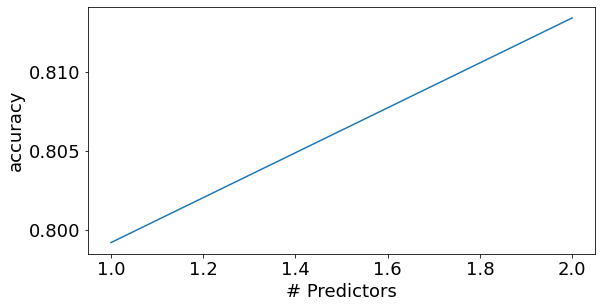

In [36]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["accuracy"])
    plt.xlabel('# Predictors')
    plt.ylabel('accuracy')

best_sub_plots()

In [38]:
models_best["model"][2].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                isAlive   No. Observations:                  472
Model:                          Logit   Df Residuals:                      458
Method:                           MLE   Df Model:                           13
Date:                Sun, 05 Mar 2023   Pseudo R-squ.:                  0.3263
Time:                        16:20:32   Log-Likelihood:                -185.17
converged:                      False   LL-Null:                       -274.86
Covariance Type:            nonrobust   LLR p-value:                 2.278e-31
================================================================================================================================
                                                                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------
Intercept                                                       53.7388        nan        nan        nan         nan         nan
house_alive_binned[T.Interval(0.31, 0.5, closed='right')]        0.0805      0.534      0.151      0.880      -0.966       1.127
house_alive_binned[T.Interval(0.5, 0.571, closed='right')]       0.2189      0.910      0.240      0.810      -1.565       2.003
house_alive_binned[T.Interval(0.571, 0.717, closed='right')]     0.7437      0.534      1.392      0.164      -0.304       1.791
house_alive_binned[T.Interval(0.717, 0.75, closed='right')]      1.0076      0.838      1.202      0.229      -0.635       2.650
house_alive_binned[T.Interval(0.75, 0.833, closed='right')]      1.4612      0.629      2.324      0.020       0.229       2.693
house_alive_binned[T.Interval(0.833, 0.87, closed='right')]      1.7829      0.922      1.933      0.053      -0.025       3.591
house_alive_binned[T.Interval(0.87, 1.0, closed='right')]        5.0760      1.127      4.504      0.000       2.867       7.285
culture[T.few_survive]                                         -55.4775        nan        nan        nan         nan         nan
culture[T.half_survive]                                        -54.0312        nan        nan        nan         nan         nan
culture[T.many_survive]                                        -53.5566        nan        nan        nan         nan         nan
culture[T.morethanhalf_survive]                                -54.3366        nan        nan        nan         nan         nan
culture[T.most_survive]                                        -53.8188        nan        nan        nan         nan         nan
culture[T.none_survive]                                        -76.9172        nan        nan        nan         nan         nan
================================================================================================================================
"""